# Caverns with constraints

In [1]:
import glob
import os
from zipfile import ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import xarray as xr
from geocube.api.core import make_geocube
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

CRS = 23029

## Halite data

In [3]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

In [4]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset

    Parameters
    ----------
    dat_path : path to the .dat files
    dat_crs : CRS
    """

    gdf = {}
    for dat_file in [
        x for x in glob.glob(
            os.path.join(dat_path, "*.dat")
        ) if "Zone" not in x
    ]:

        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[-1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[-1][:-4]]["data"] = (
            os.path.split(dat_file)[-1][:-4]
        )

    # find data resolution
    gdf_xr = gdf[list(gdf.keys())[0]].set_index(["X", "Y"]).to_xarray()
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["geometry"] = gpd.points_from_xy(gdf.X, gdf.Y, crs=dat_crs)
    gdf = gpd.GeoDataFrame(gdf)
    gdf.drop(columns=["X", "Y"], inplace=True)

    # convert to Xarray dataset
    xds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # split variables and halite members
    xds_ = {}
    for d in xds["data"].values:
        halite_member = d.split(" ")[0]
        if halite_member == "Presall":
            halite_member = "Preesall"
        unit = d.split(" ")[-1]
        zvar = d.split("Halite ")[-1].split(" XYZ")[0]
        xds_[d] = xds.sel(data=d).assign_coords(
            halite=halite_member
        ).expand_dims(dim="halite").drop_vars("data")
        xds_[d] = xds_[d].rename({"Z": zvar.replace(" ", "")})
        xds_[d][zvar.replace(" ", "")] = (
            xds_[d][zvar.replace(" ", "")].assign_attrs(
                units=unit, long_name=zvar
            )
        )

    xds = xr.combine_by_coords(xds_.values(), combine_attrs="override")

    # create extent polygon
    dat_extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    dat_extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (dat_extent[" X"][0], dat_extent[" Y"][0]),
            (dat_extent[" X"][1], dat_extent[" Y"][1]),
            (dat_extent[" X"][2], dat_extent[" Y"][2]),
            (dat_extent[" X"][3], dat_extent[" Y"][3])
        ]),
        crs=dat_crs
    )

    return xds, dat_extent

In [5]:
ds, extent = read_dat_file(DATA_DIR, CRS)

In [6]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Zones of interest

In [7]:
def zones_of_interest(dat_xr, dat_crs, min_thickness, min_depth, max_depth):
    """
    Generate a (multi)polygon of the zones of interest by applying thickness
    and depth constraints.

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_crs : CRS
    min_thickness : minimum halite thickness [m]
    min_depth : minimum halite top depth [m]
    max_depth : maximum halite top depth [m]

    Returns
    -------
    - A (multi)polygon geodataframe of the zones of interest
    """

    zdf = dat_xr.where(
        (
            (dat_xr.Thickness >= min_thickness)
            & (dat_xr.TopDepth >= min_depth)
            & (dat_xr.TopDepth <= max_depth)
        ),
        drop=True
    )

    # zones of interest polygon
    zdf = zdf.max(
        dim="halite"
    )["Thickness"].to_dataframe().dropna().reset_index()
    zdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(
            gpd.points_from_xy(zdf.x, zdf.y)
        ).buffer(100).envelope,
        crs=dat_crs
    ).dissolve()

    return zdf

## Generate caverns in a regular hexagonal grid configuration

In [8]:
def generate_caverns(dat_extent, dat_crs, zones_df, diameter, separation):
    """
    Generate caverns in a regular hexagonal grid as proposed by Williams
    et al. (2022): https://doi.org/10.1016/j.est.2022.105109.
    Hexagonal gridding method based on
    https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html.

    Parameters
    ----------
    dat_extent : extent of the data
    dat_crs : CRS
    zones_df : zones of interest
    diameter : diameter of the cavern [m]
    separation : cavern separation distance [m]

    Returns
    -------
    - A polygon geodataframe of potential caverns
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    a = np.sin(np.pi / 3)
    cols = np.arange(np.floor(xmin_), np.ceil(xmax_), 3 * separation)
    rows = np.arange(np.floor(ymin_) / a, np.ceil(ymax_) / a, separation)

    cavern_df = []
    for x in cols:
        for i, y in enumerate(rows):
            if (i % 2 == 0):
                x0 = x
            else:
                x0 = x + 1.5 * separation

            # hexagon vertices
            cavern_df.append(shapely.geometry.Point(x0, y * a))
            cavern_df.append(shapely.geometry.Point(x0 + separation, y * a))
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + (1.5 * separation), (y + separation) * a
                    )
                )
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + separation, (y + (2 * separation)) * a
                )
            )
            cavern_df.append(
                shapely.geometry.Point(x0, (y + (2 * separation)) * a)
            )
            cavern_df.append(
                shapely.geometry.Point(
                    x0 - (0.5 * separation), (y + separation) * a
                )
            )
            # hexagon centroid
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + (0.5 * separation), (y + separation) * a
                )
            )

    # generate caverns using hexagon vertices and centroids
    cavern_df = gpd.GeoDataFrame(
        geometry=gpd.GeoDataFrame(
            geometry=cavern_df, crs=dat_crs
        ).drop_duplicates().buffer(diameter / 2)
    )

    # clip caverns to the zones of interest
    cavern_df = gpd.sjoin(cavern_df, zones_df, predicate="within")

    print("Number of potential caverns:", len(cavern_df))

    return cavern_df

## Constraints

### Exploration wells

In [9]:
DATA_DIR = os.path.join(
    "data", "exploration-wells-irish-offshore",
    "Exploration_Wells_Irish_Offshore.shapezip.zip"
)

wells = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [10]:
wells = wells[wells["AREA"].str.contains("Kish")].to_crs(CRS)

# 500 m buffer - suggested in draft OREDP II p. 108
wells_b = gpd.GeoDataFrame(geometry=wells.buffer(500))

### Wind farms

In [11]:
DATA_DIR = os.path.join(
    "data", "wind-farms-foreshore-process", "wind-farms-foreshore-process.zip"
)

wind_farms = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [12]:
# wind farms near Kish Basin
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = wind_farms.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index().sort_values("Name")

### Dublin Bay Biosphere

In [13]:
DATA_DIR = os.path.join(
    "data", "heritage", "unesco-global-geoparks-and-biospheres.zip"
)

biospheres = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [14]:
biospheres = biospheres[biospheres["Name"].str.contains("Dublin")].to_crs(CRS)

# 5 km buffer - suggested in draft OREDP II p. 58
biospheres_b = gpd.GeoDataFrame(geometry=biospheres.buffer(5000))

### Frequent shipping routes

In [15]:
DATA_DIR = os.path.join(
    "data", "shipping", "shipping_frequently_used_routes.zip"
)

shipping = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [16]:
shipping = shipping.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index()

# routes near Kish Basin
# 1NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping_b = gpd.GeoDataFrame(geometry=shipping.buffer(1852))

## Calculate

In [18]:
# numbers used in HYSS calculations
# # thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
zones = zones_of_interest(ds, CRS, 300, 1000, 1500)
caverns = generate_caverns(extent, CRS, zones, 85, 330)

Number of potential caverns: 391


In [19]:
# exclude exploration wells
caverns = caverns.overlay(wells_b, how="difference")
print("Number of potential caverns:", len(caverns))

Number of potential caverns: 391


In [20]:
# exclude wind farms
caverns = caverns.overlay(wind_farms, how="difference")
print("Number of potential caverns:", len(caverns))

Number of potential caverns: 378


In [21]:
# exclude biosphere
caverns = caverns.overlay(biospheres_b, how="difference")
print("Number of potential caverns:", len(caverns))

Number of potential caverns: 373


In [22]:
#exclude shipping routes
caverns = caverns.overlay(shipping_b, how="difference")
print("Number of potential caverns:", len(caverns))

Number of potential caverns: 227


## Crop data layers

In [23]:
# land boundary
DATA_DIR = os.path.join(
    "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
)

land = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

land = land.dissolve().to_crs(CRS)

In [24]:
# crop land areas from biosphere
biospheres = biospheres.overlay(land, how="difference")

In [25]:
# create exclusion buffer
buffer = pd.concat([biospheres_b, wells_b, shipping_b]).dissolve()

In [26]:
# crop land areas from buffer
buffer = buffer.overlay(land, how="difference")

In [27]:
# crop constraints from buffer
buffer = buffer.overlay(pd.concat([biospheres, wind_farms]), how="difference")

## Plot

In [34]:
def plot_map(dat_xr, var, stat):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    var : variable
    stat : statistic (max / min / mean)
    """

    # estimates
    print("Number of potential caverns:", len(caverns))
    # print(f"Total volume: {len(caverns) * 5e5:.2E} m\N{SUPERSCRIPT THREE}")
    # print(f"Storage capacity: {len(caverns) * 105.074 / 1e3:.2f} TWh")

    # initialise figure
    plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.epsg(CRS))

    # configure colour bar based on variable
    if var == "TopTWT":
        units = "ms"
    else:
        units = "m"
    cbar_label = (f"{dat_xr[var].attrs['long_name']} [{units}]")
    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        cbar_label = f"Maximum Halite {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        cbar_label = f"Minimum Halite {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        cbar_label = f"Mean Halite {cbar_label}"

    # plot halite data
    plot_data[var].plot.contourf(
        cmap="jet", alpha=.65, robust=True, levels=15,
        cbar_kwargs={"label": cbar_label}
    )

    # configure map limits
    plt.xlim(xmin, xmax)
    # plt.ylim(ymin - 4000, ymax + 4000)
    plt.ylim(ymin, ymax)

    # add constraint layers
    buffer.plot(ax=ax, facecolor="none", edgecolor="slategrey", hatch="///")
    wells.centroid.plot(ax=ax, color="black", marker="x")
    wind_farms.plot(ax=ax, facecolor="none", hatch="///", edgecolor="black")
    biospheres.plot(
        ax=ax, facecolor="none", edgecolor="forestgreen", hatch="///"
    )
    shipping.plot(ax=ax, color="deeppink", linewidth=3)

    # add caverns
    caverns.centroid.plot(ax=ax, markersize=7, color="black", edgecolor="none")
    # caverns.plot(ax=ax, edgecolor="none", facecolor="black")

    # configure legend entries
    legend_handles = [
        Line2D(
            [0], [0], marker=".", markersize=7, markeredgecolor="none",
            markerfacecolor="black", linewidth=0, label="Salt cavern"
        )
    ]
    legend_handles.append(
        Line2D(
            [0], [0], marker="x", linewidth=0, markeredgecolor="black",
            label="Exploration well"
        )
    )
    legend_handles.append(
        Line2D([0], [0], color="deeppink", label="Shipping route", linewidth=3)
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none", hatch="///", edgecolor="black", label="Wind farm"
        )
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none", edgecolor="forestgreen", hatch="///",
            label="Biosphere"
        )
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none", hatch="///", edgecolor="slategrey",
            label="Exclusion buffer"
        )
    )

    # add basemap and map elements
    cx.add_basemap(ax, crs=CRS, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"}, alpha=.25,
        color="darkslategrey"
    )
    ax.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

Number of potential caverns: 227


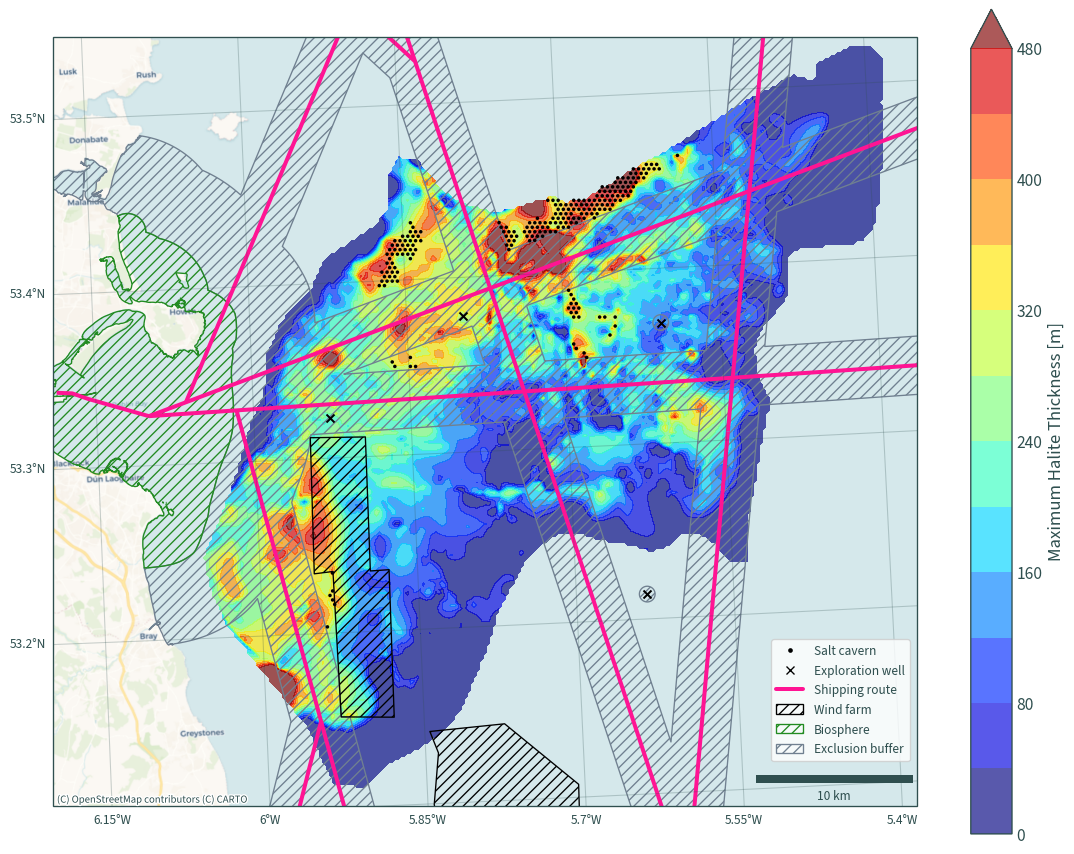

In [35]:
plot_map(ds, "Thickness", "max")